In [1]:
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
import string
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics # confusion matrix, MSE etc.

In [2]:
path_to_data = '/Users/t.z.cheng/Google_Drive/Research/Delaydoesmatter/real_exp/exp3_20CR11/results/20CR11_5f7d2e104bfca86e4f58ef9a-data.csv'

In [3]:
## Read the data
df = pd.read_csv(path_to_data)

In [4]:
## Tasks & Conditions
tasks = ['maintaskTrials_2_l','maintaskTrials_2_s','maintaskTrials_2_l_reversekey','maintaskTrials_2_s_reversekey']
conds = ['300ms_delay_2_51','300ms_delay_2_52','300ms_delay_2_53','300ms_delay_2_54','300ms_delay_2_55','300ms_delay_2_56',
        '300ms_delay_2_81','300ms_delay_2_82','300ms_delay_2_83','300ms_delay_2_84','300ms_delay_2_85','300ms_delay_2_86',
        '300ms_delay_2_91','300ms_delay_2_92','300ms_delay_2_93','300ms_delay_2_94','300ms_delay_2_95','300ms_delay_2_96']
subID = df['participant_id'].unique()

In [5]:
## Parameters
threshold = .55

In [6]:
df_clean = df[(df['stimuli_presented'].isin(conds)) & (df['trial_template'].isin(tasks))]

In [7]:
onset = []
length = []
df_clean = df_clean.set_index(pd.Index(np.arange(0,len(df_clean)))) # change the index for the for loop

for i in np.arange(0,len(df_clean)):
    stimuli_presented = df_clean['stimuli_presented'][i].split('_')
    condition = stimuli_presented[-1]
    condition = list(condition)
    onset.append(condition[0])
    length.append(condition[1])

In [8]:
df_clean['Onset'] = onset
df_clean['Length'] = length

In [9]:
df_clean.head()

,expt_id,group_id,network_error_repeat,participant_id,participation_duration,response_correct,response_mode,response_name,response_rt,response_target,response_type,response_value,session_id,stimuli_presented,trial_duration,trial_num,trial_template,Onset,Length
0,5f7d2e104bfca86e4f58ef9a,Group_FJ,0,885d1eea80d979e945a735ff9ec5071e70109282de3476...,1704,True,keypress,testresponse_s_F,820,['Shorter'],choice-response,Shorter,5fbc5590be36f3ba328bd883,300ms_delay_2_51,4599,19,maintaskTrials_2_s,5,1
1,5f7d2e104bfca86e4f58ef9a,Group_FJ,0,885d1eea80d979e945a735ff9ec5071e70109282de3476...,1704,False,keypress,testresponse_s_F,526,['Shorter'],choice-response,Longer,5fbc5590be36f3ba328bd883,300ms_delay_2_91,5341,20,maintaskTrials_2_s,9,1
2,5f7d2e104bfca86e4f58ef9a,Group_FJ,0,885d1eea80d979e945a735ff9ec5071e70109282de3476...,1704,True,keypress,testresponse_s_F,1024,['Shorter'],choice-response,Shorter,5fbc5590be36f3ba328bd883,300ms_delay_2_93,5019,21,maintaskTrials_2_s,9,3
3,5f7d2e104bfca86e4f58ef9a,Group_FJ,0,885d1eea80d979e945a735ff9ec5071e70109282de3476...,1704,False,keypress,testresponse_s_F,2105,['Shorter'],choice-response,Longer,5fbc5590be36f3ba328bd883,300ms_delay_2_82,5980,22,maintaskTrials_2_s,8,2
4,5f7d2e104bfca86e4f58ef9a,Group_FJ,0,885d1eea80d979e945a735ff9ec5071e70109282de3476...,1704,False,keypress,testresponse_l_J,518,['Longer'],choice-response,Shorter,5fbc5590be36f3ba328bd883,300ms_delay_2_94,4999,23,maintaskTrials_2_l,9,4


In [10]:
len(df_clean)

13608

In [11]:
## Number of subjects, trials & conditions for each subjects
n_subj = len(df_clean['participant_id'].unique())
n_trial = len(df_clean['trial_num'].unique())
n_conds = len(df_clean['stimuli_presented'].unique())
print('Participant_number:', n_subj,'Trial number:', n_trial,'Condition number:', n_conds, sep='\n')

Participant_number:
63
Trial number:
216
Condition number:
18


### Accuracy

In [12]:
Accuracy = []
Acc_cond = []
Easiest = []
Easiest_idx = [conds.index('300ms_delay_2_81'),conds.index('300ms_delay_2_86')]
for sub in subID:
    tmpdf = df_clean[df_clean['participant_id'] == sub]
    for cond in conds:
        tmpAcc = np.mean(tmpdf[tmpdf['stimuli_presented'] == cond]['response_correct'])
        Acc_cond.append(tmpAcc)
    Easiest.append((Acc_cond[Easiest_idx[0]] + Acc_cond[Easiest_idx[-1]])/len(Easiest_idx)) # average accuracy of 81 and 86 
    Accuracy.append(Acc_cond)
    Acc_cond = []

In [13]:
## Outliers based on the accuracy of the easiest trials 
Acc_easiest = pd.Series(Easiest, index=df_clean['participant_id'].unique())
print(Acc_easiest.describe())
t = Acc_easiest[Acc_easiest >= threshold]
# print("Subjects who have >=",threshold, "accuracy for the easiest trials:",len(t))

count    63.000000
mean      0.590608
std       0.151260
min       0.291667
25%       0.500000
50%       0.583333
75%       0.708333
max       0.916667
dtype: float64


In [14]:
## Exclude the outliers
df_Accuracy = pd.DataFrame(data = Accuracy, index = subID, columns = conds)
Acc_final_sample = df_Accuracy[Acc_easiest >= threshold]
Acc_final_sample.head()
print('Final sample size:', len(Acc_final_sample))
# Acc_final_sample.describe()

Final sample size: 34


In [15]:
outliers = Acc_easiest < threshold
outliers = outliers[outliers == True]
df_clean_nooutlier = df_clean[~df_clean['participant_id'].isin(outliers.index)]
len(df_clean_nooutlier)/216

34.0

In [16]:
## Save the dataset to csv
df_clean_nooutlier.to_csv(path_or_buf = '/Users/t.z.cheng/Google_Drive/Research/Delaydoesmatter/real_exp/exp3_20CR11/results/20CR11_clean_n34.csv', index=True)

In [ ]:
## Early, ontime, late
early = [conds.index('300ms_delay_2_51'),conds.index('300ms_delay_2_52'),conds.index('300ms_delay_2_53'),conds.index('300ms_delay_2_54'),conds.index('300ms_delay_2_55'),conds.index('300ms_delay_2_56')]
ontime = [conds.index('300ms_delay_2_81'),conds.index('300ms_delay_2_82'),conds.index('300ms_delay_2_83'),conds.index('300ms_delay_2_84'),conds.index('300ms_delay_2_85'),conds.index('300ms_delay_2_86')]
late = [conds.index('300ms_delay_2_91'),conds.index('300ms_delay_2_92'),conds.index('300ms_delay_2_93'),conds.index('300ms_delay_2_94'),conds.index('300ms_delay_2_95'),conds.index('300ms_delay_2_96')]
Acc_early = Acc_final_sample.iloc[:, early].mean(axis = 1)
Acc_ontime = Acc_final_sample.iloc[:, ontime].mean(axis = 1)
Acc_late = Acc_final_sample.iloc[:, late].mean(axis = 1)
print("Accuracy")
print("Early:", np.mean(Acc_early))
print("Ontime:", np.mean(Acc_ontime))
print("Late:",np.mean(Acc_late))


In [ ]:
## Visualization: bar plot
ACC_plot = pd.DataFrame({'Conditions': conds, 'acc': np.mean(Acc_final_sample, axis = 0)})
ax = ACC_plot.plot.bar(rot = 0)

### Proportion short

In [17]:
resp_short = []
resp_short = [True if d == 'Shorter' else False for d in df_clean['response_value']]

In [18]:
df_clean['resp_short'] = resp_short

In [19]:
PPS = []
PPS_cond = []
for sub in subID:
    tmpdf = df_clean[df_clean['participant_id'] == sub]
    for cond in conds:
        tmpPPS = np.mean(tmpdf[tmpdf['stimuli_presented'] == cond]['resp_short'])
        PPS_cond.append(tmpPPS)
    PPS.append(PPS_cond)
    PPS_cond = []

In [20]:
df_PPS = pd.DataFrame(data = PPS, index = subID, columns = conds)

In [21]:
PPS_final_sample = df_PPS[Acc_easiest >= threshold]
PPS_final_sample.head()
PPS_final_sample.describe()

,300ms_delay_2_51,300ms_delay_2_52,300ms_delay_2_53,300ms_delay_2_54,300ms_delay_2_55,300ms_delay_2_56,300ms_delay_2_81,300ms_delay_2_82,300ms_delay_2_83,300ms_delay_2_84,300ms_delay_2_85,300ms_delay_2_86,300ms_delay_2_91,300ms_delay_2_92,300ms_delay_2_93,300ms_delay_2_94,300ms_delay_2_95,300ms_delay_2_96
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.772059,0.730392,0.654412,0.629902,0.534314,0.519608,0.683824,0.551471,0.490196,0.438725,0.299020,0.274510,0.558824,0.477941,0.416667,0.335784,0.286765,0.269608
std,0.184989,0.185840,0.200097,0.181408,0.209334,0.241922,0.170140,0.180038,0.170122,0.204442,0.136265,0.156951,0.234386,0.223144,0.219043,0.194067,0.192659,0.202113
min,0.333333,0.333333,0.166667,0.333333,0.083333,0.083333,0.333333,0.166667,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000
25%,0.666667,0.604167,0.520833,0.500000,0.416667,0.333333,0.583333,0.437500,0.416667,0.333333,0.187500,0.166667,0.416667,0.333333,0.250000,0.250000,0.166667,0.083333
50%,0.750000,0.750000,0.625000,0.583333,0.583333,0.541667,0.750000,0.541667,0.500000,0.416667,0.250000,0.250000,0.583333,0.500000,0.416667,0.333333,0.250000,0.250000
75%,0.916667,0.833333,0.812500,0.812500,0.666667,0.666667,0.750000,0.645833,0.583333,0.562500,0.395833,0.395833,0.750000,0.645833,0.562500,0.416667,0.416667,0.416667
max,1.000000,1.000000,1.000000,1.000000,0.916667,0.916667,1.000000,0.916667,0.833333,0.916667,0.583333,0.666667,1.000000,0.916667,0.916667,0.833333,0.750000,0.750000


In [22]:
## Early, ontime, late
early = [conds.index('300ms_delay_2_51'),conds.index('300ms_delay_2_52'),conds.index('300ms_delay_2_53'),conds.index('300ms_delay_2_54'),conds.index('300ms_delay_2_55'),conds.index('300ms_delay_2_56')]
ontime = [conds.index('300ms_delay_2_81'),conds.index('300ms_delay_2_82'),conds.index('300ms_delay_2_83'),conds.index('300ms_delay_2_84'),conds.index('300ms_delay_2_85'),conds.index('300ms_delay_2_86')]
late = [conds.index('300ms_delay_2_91'),conds.index('300ms_delay_2_92'),conds.index('300ms_delay_2_93'),conds.index('300ms_delay_2_94'),conds.index('300ms_delay_2_95'),conds.index('300ms_delay_2_96')]
PPS_early = PPS_final_sample.iloc[:, early].mean(axis = 1)
PPS_ontime = PPS_final_sample.iloc[:, ontime].mean(axis = 1)
PPS_late = PPS_final_sample.iloc[:, late].mean(axis = 1)
print("Proportion short")
print("Early:", np.mean(PPS_early))
print("Ontime:", np.mean(PPS_ontime))
print("Late:",np.mean(PPS_late))

Proportion short
Early: 0.6401143790849673
Ontime: 0.4562908496732026
Late: 0.3909313725490196


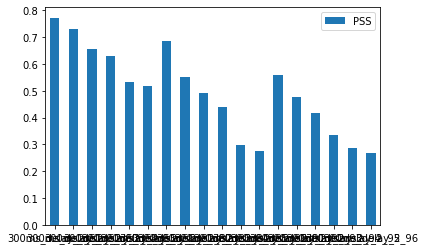

In [23]:
## Visualization: bar plot
PSS_plot = pd.DataFrame({'Conditions': conds, 'PSS': np.mean(PPS_final_sample, axis = 0)})
ax = PSS_plot.plot.bar(rot = 0)

### To do...
1. Response key effect
2. Decide the outliers and fill in the outliers
3. Statistics

### Reaciton time